<a href="https://colab.research.google.com/github/hydradon/clever-challenge/blob/master/part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An approach using a shallow (3-layer) neural network

In this notebook, I used the [DataFrame.shift](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) function to connect 2 consecutive events. The information of event t-1, and the features of event t are used as features to predict the class of event t. At first, I attempted to use only the features of event t-1, but the accuracy is very low (around 55%+ ).

I also attempted on LSTM but its performance is slightly lower than that of the conventional neural network layer.



In [ ]:
import pandas as pd

# Initial inspection shows that the timestamp column is Unix epoch time up to the Second granularity
dateparse = lambda timestamp: pd.to_datetime(timestamp, unit='s')

data = pd.read_csv("seq/sample.csv", 
                    index_col="timestamp",
                    date_parser=dateparse,
                    infer_datetime_format=True,
                    parse_dates=['timestamp'])
# View a sample of 10 rows
data.sample(5)

,event_id,class,f1,f2,f3,f3.1,f4,f5,f6,f7,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-10-16 14:33:26,813077,1,1,58,109,3.823596,544,660,1294.431193,31,...,1,0,0,0,0,0,0,0,0,0
2018-07-25 14:49:43,823188,1,1,5,14,2.205659,329,112,1750.785714,67,...,1,0,0,0,0,0,0,0,0,0
2018-03-05 17:46:58,817409,1,1,3,24,2.535026,490,198,813.666667,37,...,0,0,0,0,0,0,0,0,0,0
2018-03-19 10:43:06,818066,0,1,1,1,0.000000,1,0,113.000000,1,...,1,0,0,0,0,0,0,0,0,0
2018-07-27 17:03:41,823333,1,1,12,24,1.670039,1087,712,524.166667,47,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
# Check any NA values
data.isna().sum()

# Inspect distribution of data
data.describe()

,event_id,class,f1,f2,f3,f3.1,f4,f5,f6,f7,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
count,18417.000000,18417.000000,18417.000000,18417.000000,18417.000000,18417.000000,1.841700e+04,1.841700e+04,18417.000000,18417.000000,...,18417.000000,18417.0,18417.0,18417.0,18417.0,18417.0,18417.0,18417.0,18417.0,18417.0
mean,820275.000000,0.451539,1.083618,7.641527,46.805343,0.948172,5.282271e+03,1.876271e+03,662.242501,11.078732,...,0.953901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,5316.674289,0.497660,0.408374,134.453030,1375.277466,1.077906,3.433018e+05,4.628975e+04,1103.655690,13.299995,...,0.765509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,811067.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-142.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,815671.000000,0.000000,1.000000,1.000000,1.000000,0.000000,4.000000e+00,1.000000e+00,88.000000,3.000000,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,820275.000000,0.000000,1.000000,2.000000,3.000000,0.691761,2.200000e+01,8.000000e+00,286.680000,7.000000,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,824879.000000,1.000000,1.000000,3.000000,8.000000,1.507725,1.200000e+02,4.800000e+01,771.500000,14.000000,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,829483.000000,1.000000,9.000000,16257.000000,172188.000000,10.287316,4.534482e+07,3.758535e+06,26059.000000,163.000000,...,12.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Looks like the below features only have constant 0 for all rows f11, f16, f19, f22 - f30
const_col = ["f11", "f16", "f19"] + ["f{}".format(num) for num in range(22,31)]

# dropping these cols
data.drop(columns=const_col, inplace=True, errors='ignore')

In [ ]:
# Read resource dataset
res = pd.read_csv("seq/res.csv")
res.sample(5)

,event_id,res_id
31651,811067,15356959
585337,817558,15388781
500338,815210,15547254
484814,815050,15605105
442086,814415,15558597


In [ ]:
import numpy as np

def group_res_by_event(df):
    keys, values = df.sort_values('event_id').values.T
    ukeys, index = np.unique(keys, True)
    arrays = np.split(values, index[1:])
    df2 = pd.DataFrame({'event_id':ukeys, 'res_id':[list(a) for a in arrays]})
    return df2

res_grp = group_res_by_event(res)
res_grp

,event_id,res_id
0,811067,"[15325277, 15440054, 15440055, 15440056, 15440..."
1,811068,[15495262]
2,811069,"[15501813, 15501809, 15501812, 15501810, 15501..."
3,811070,"[15505228, 15505227, 15505225, 15505229, 15505..."
4,811071,"[15449230, 15449260, 15449270, 15449271, 15449..."
...,...,...
18303,829479,"[15475824, 15475827, 15475828, 15475830, 15475..."
18304,829480,"[15658697, 15658696]"
18305,829481,"[15666344, 15632590, 15548015, 15666343, 15632..."
18306,829482,"[15658538, 15695471, 15658424]"


In [ ]:
# Merging 2 dataset
data_w_res = data.reset_index().merge(res_grp, on="event_id", how="left").set_index("timestamp")

# Fill event with no resource an empty resource list
data_w_res['res_id'] = data_w_res['res_id'].apply(lambda d: d if isinstance(d, list) else [])

data_w_res.head(5)

,event_id,class,f1,f2,f3,f3.1,f4,f5,f6,f7,...,f10,f12,f13,f14,f15,f17,f18,f20,f21,res_id
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-11-21 14:17:52,811067,1,9,16257,172188,10.287316,45344815,0,0.000000,1,...,0,0,9230,0,0.0,0.0,0.0,0.0,0,"[15325277, 15440054, 15440055, 15440056, 15440..."
2016-12-01 16:23:01,811068,0,1,1,1,0.000000,2,1,3.000000,2,...,0,0,9231,0,0.0,0.0,0.0,0.0,0,[15495262]
2016-12-02 09:14:02,811069,1,7,1731,10212,7.460379,2000330,84524,157.627693,1,...,172188,172076,9230,0,0.0,0.0,0.0,0.0,0,"[15501813, 15501809, 15501812, 15501810, 15501..."
2016-12-02 10:18:05,811070,0,1,4,12,1.665603,353,0,0.000000,1,...,0,0,9232,0,0.0,0.0,0.0,0.0,0,"[15505228, 15505227, 15505225, 15505229, 15505..."
2016-12-02 10:18:39,811071,0,2,4,22,0.919741,6263,4346,684.409091,2,...,12,0,9232,0,0.0,0.0,0.0,0.0,0,"[15449230, 15449260, 15449270, 15449271, 15449..."


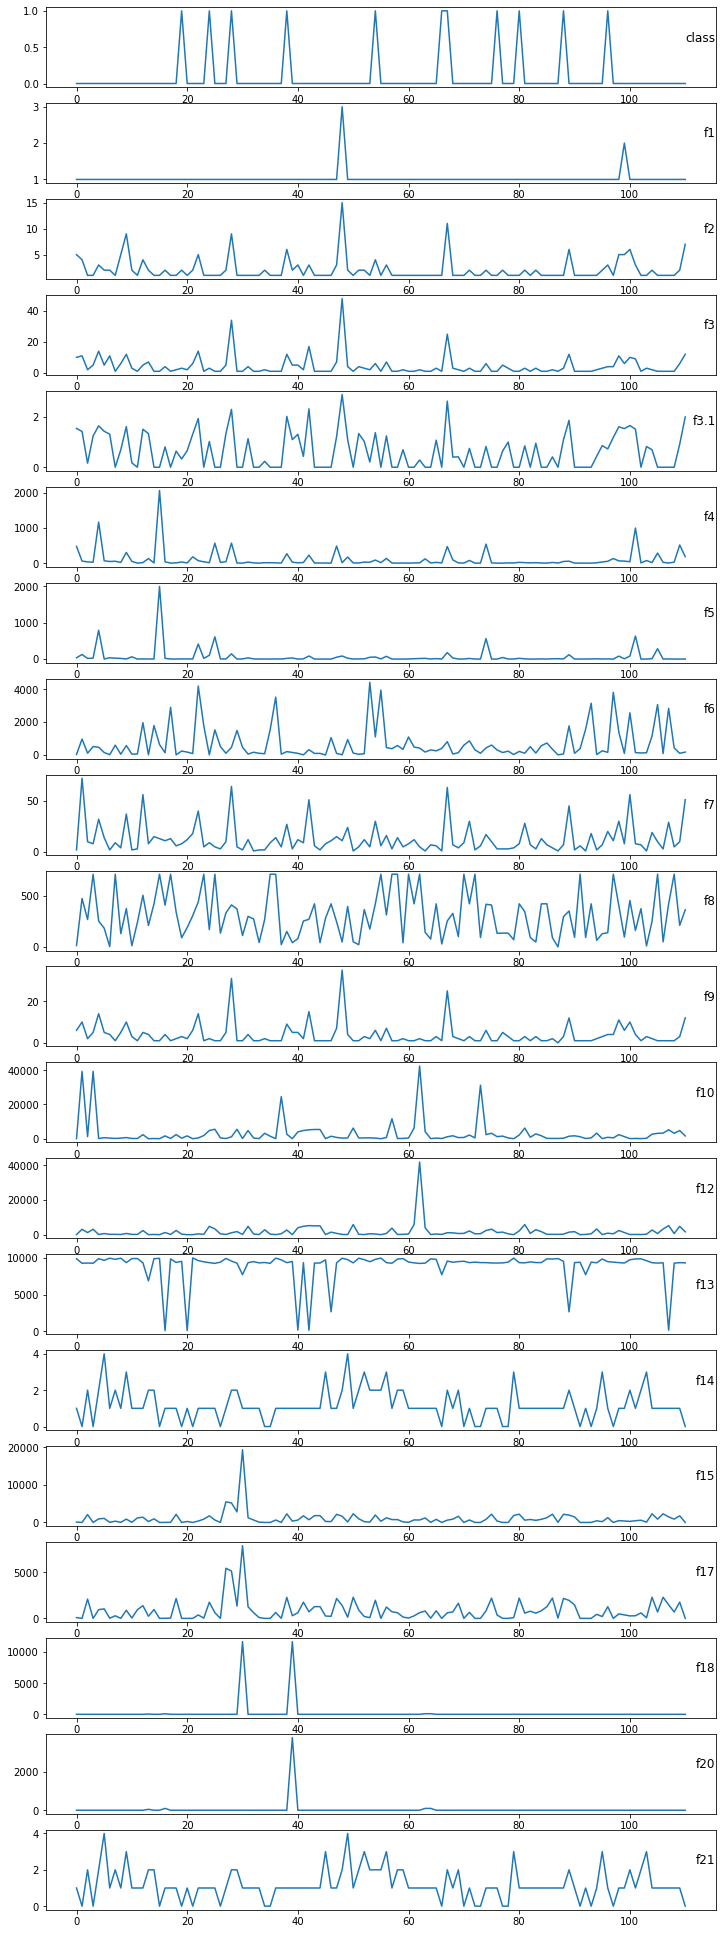

In [ ]:
import matplotlib.pyplot as plt

# visualize class and features over a day (31st Oct 2018)
values = data_w_res.loc['2018-10-31 00:00:00':'2018-10-31 23:59:59'].values
# specify columns to plot
groups = list(range(1, 21))
i = 1
# plot each column
plt.rcParams["figure.figsize"] = 12,35
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(data_w_res.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [ ]:
data_w_res.drop(columns=["res_id", "event_id"], inplace=True, errors='ignore') # Trial without using res_id
data_w_res["time_stamp"] = data_w_res.index
data_w_res.head(5)

,class,f1,f2,f3,f3.1,f4,f5,f6,f7,f8,...,f10,f12,f13,f14,f15,f17,f18,f20,f21,time_stamp
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-11-21 14:17:52,1,9,16257,172188,10.287316,45344815,0,0.000000,1,0.000000,...,0,0,9230,0,0.0,0.0,0.0,0.0,0,2016-11-21 14:17:52
2016-12-01 16:23:01,0,1,1,1,0.000000,2,1,3.000000,2,10.086910,...,0,0,9231,0,0.0,0.0,0.0,0.0,0,2016-12-01 16:23:01
2016-12-02 09:14:02,1,7,1731,10212,7.460379,2000330,84524,157.627693,1,2.579979,...,172188,172076,9230,0,0.0,0.0,0.0,0.0,0,2016-12-02 09:14:02
2016-12-02 10:18:05,0,1,4,12,1.665603,353,0,0.000000,1,0.000000,...,0,0,9232,0,0.0,0.0,0.0,0.0,0,2016-12-02 10:18:05
2016-12-02 10:18:39,0,2,4,22,0.919741,6263,4346,684.409091,2,10.341428,...,12,0,9232,0,0.0,0.0,0.0,0.0,0,2016-12-02 10:18:39


In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

cur_data = data_w_res.copy()
encoder = LabelEncoder()
cur_data["class"] = encoder.fit_transform(cur_data["class"])

In [ ]:
# scale feature columns
ft_cols = ['f1', 'f2', 'f3', 'f3.1', 'f4', 'f5', 'f6', 'f7',
            'f8', 'f9', 'f10', 'f12', 'f13', 'f14', 'f15', 
            'f17', 'f18', 'f20','f21'] # 19 features

# ensure all data is float
cur_data[ft_cols] = cur_data[ft_cols].astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))

cur_data[ft_cols] = scaler.fit_transform(cur_data[ft_cols])

In [ ]:
cur_data

,class,f1,f2,f3,f3.1,f4,f5,f6,f7,f8,...,f10,f12,f13,f14,f15,f17,f18,f20,f21,time_stamp
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-11-21 14:17:52,1,1.000000,1.000000,1.000000,1.000000,1.000000e+00,0.000000e+00,0.005420,0.006135,0.000000,...,0.000000,0.000000,0.924543,0.000000,0.000000,0.000000,0.0,0.0,0.000000,2016-11-21 14:17:52
2016-12-01 16:23:01,0,0.111111,0.000062,0.000006,0.000000,4.410647e-08,2.660611e-07,0.005534,0.012270,0.014108,...,0.000000,0.000000,0.924644,0.000000,0.000000,0.000000,0.0,0.0,0.000000,2016-12-01 16:23:01
2016-12-02 09:14:02,1,0.777778,0.106477,0.059307,0.725202,4.411375e-02,2.248855e-02,0.011436,0.006135,0.003608,...,0.828237,0.835616,0.924543,0.000000,0.000000,0.000000,0.0,0.0,0.000000,2016-12-02 09:14:02
2016-12-02 10:18:05,0,0.111111,0.000246,0.000070,0.161908,7.784793e-06,0.000000e+00,0.005420,0.006135,0.000000,...,0.000000,0.000000,0.924744,0.000000,0.000000,0.000000,0.0,0.0,0.000000,2016-12-02 10:18:05
2016-12-02 10:18:39,0,0.222222,0.000246,0.000128,0.089405,1.381194e-04,1.156302e-03,0.031541,0.012270,0.014464,...,0.000058,0.000000,0.924744,0.000000,0.000000,0.000000,0.0,0.0,0.000000,2016-12-02 10:18:39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-06 14:15:03,0,0.111111,0.000062,0.000035,0.111751,4.829659e-06,2.660611e-05,0.028498,0.012270,1.000000,...,0.011688,0.006303,0.950532,0.083333,0.009090,0.006669,0.0,0.0,0.083333,2018-11-06 14:15:03
2018-11-06 14:16:49,0,0.111111,0.000062,0.000012,0.019441,4.322435e-06,5.321222e-07,0.007309,0.030675,0.331678,...,0.000197,0.000199,0.042043,0.083333,0.015483,0.016645,0.0,0.0,0.083333,2018-11-06 14:16:49
2018-11-06 14:17:33,0,0.111111,0.000185,0.000029,0.107489,1.279088e-06,9.578200e-06,0.042586,0.153374,0.380918,...,0.011448,0.011524,0.932872,0.083333,0.137395,0.146791,0.0,0.0,0.083333,2018-11-06 14:17:33


In [ ]:
# convert series to supervised learning, using DataFrame.shift
# to match a class with previous class and previous class's features
def series_to_supervised(dataframe, n_in=1, n_out=1, dropnan=True):
    data = dataframe.values
    df = pd.DataFrame(data, columns=dataframe.columns)
    cols, names = list(), list()
	# input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('{}(t-{})'.format(j, i)) for j in dataframe.columns]
	# forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('{}(t)'.format(j)) for j in dataframe.columns]
        else:
            names += [('{}(t+%d)'.format(j+1, i)) for j in dataframe.columns]
	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
	# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
# frame as supervised learning: using one past event, forecast one stepfoward
reframed = series_to_supervised(cur_data, n_in=1, n_out=1)

In [ ]:
print(reframed.shape) # Should be 1 row less than before processing due to shifting by 1
print(reframed.columns)

(18416, 42)
Index(['class(t-1)', 'f1(t-1)', 'f2(t-1)', 'f3(t-1)', 'f3.1(t-1)', 'f4(t-1)',
       'f5(t-1)', 'f6(t-1)', 'f7(t-1)', 'f8(t-1)', 'f9(t-1)', 'f10(t-1)',
       'f12(t-1)', 'f13(t-1)', 'f14(t-1)', 'f15(t-1)', 'f17(t-1)', 'f18(t-1)',
       'f20(t-1)', 'f21(t-1)', 'time_stamp(t-1)', 'class(t)', 'f1(t)', 'f2(t)',
       'f3(t)', 'f3.1(t)', 'f4(t)', 'f5(t)', 'f6(t)', 'f7(t)', 'f8(t)',
       'f9(t)', 'f10(t)', 'f12(t)', 'f13(t)', 'f14(t)', 'f15(t)', 'f17(t)',
       'f18(t)', 'f20(t)', 'f21(t)', 'time_stamp(t)'],
      dtype='object')


In [ ]:
# Verify the correct sequence of class at time t-1 and next instance t
reframed[["class(t-1)", 'time_stamp(t-1)', "class(t)", 'time_stamp(t)']].head(16)

,class(t-1),time_stamp(t-1),class(t),time_stamp(t)
1,1,2016-11-21 14:17:52,0,2016-12-01 16:23:01
2,0,2016-12-01 16:23:01,1,2016-12-02 09:14:02
3,1,2016-12-02 09:14:02,0,2016-12-02 10:18:05
4,0,2016-12-02 10:18:05,0,2016-12-02 10:18:39
5,0,2016-12-02 10:18:39,0,2016-12-02 15:35:26
6,0,2016-12-02 15:35:26,0,2016-12-02 16:58:26
7,0,2016-12-02 16:58:26,0,2016-12-08 17:07:09
8,0,2016-12-08 17:07:09,0,2016-12-09 13:43:08
9,0,2016-12-09 13:43:08,1,2016-12-12 13:30:33
10,1,2016-12-12 13:30:33,1,2016-12-13 13:16:32


In [ ]:
# Drop all features of instance t (the instance we need to predict
# since we only know the features at instance t-1)
# Note that t-1 is the NOW, t is the future to predict
# future_ft = ['f1(t)', 'f2(t)', 'f3(t)', 'f3.1(t)', 'f4(t)', 'f5(t)', 'f6(t)', 'f7(t)', 'f8(t)', 'f9(t)',
#             'f10(t)', 'f12(t)', 'f13(t)', 'f14(t)', 'f15(t)', 'f17(t)', 'f18(t)', 'f20(t)', 'f21(t)']
# reframed.drop(columns=future_ft, inplace=True, errors='ignore')
# reframed.head(5)

In [ ]:
# splitting into train and test set
# train: 2016, 2017, first half of 2018 data
train = reframed[('2016-01-01 00:00:00' <= reframed["time_stamp(t-1)"]) &  (reframed["time_stamp(t-1)"] <= '2018-06-30 23:59:59')]
train

,class(t-1),f1(t-1),f2(t-1),f3(t-1),f3.1(t-1),f4(t-1),f5(t-1),f6(t-1),f7(t-1),f8(t-1),...,f10(t),f12(t),f13(t),f14(t),f15(t),f17(t),f18(t),f20(t),f21(t),time_stamp(t)
1,1,1,1,1,1,1,0,0.00541964,0.00613497,0,...,0,0,0.924644,0,0,0,0,0,0,2016-12-01 16:23:01
2,0,0.111111,6.1512e-05,5.80761e-06,0,4.41065e-08,2.66061e-07,0.00553414,0.0122699,0.0141076,...,0.828237,0.835616,0.924543,0,0,0,0,0,0,2016-12-02 09:14:02
3,1,0.777778,0.106477,0.0593073,0.725202,0.0441138,0.0224885,0.0114357,0.00613497,0.00360837,...,0,0,0.924744,0,0,0,0,0,0,2016-12-02 10:18:05
4,0,0.111111,0.000246048,6.96913e-05,0.161908,7.78479e-06,0,0.00541964,0.00613497,0,...,5.77209e-05,0,0.924744,0,0,0,0,0,0,2016-12-02 10:18:39
5,0,0.222222,0.000246048,0.000127767,0.0894053,0.000138119,0.0011563,0.0315411,0.0122699,0.0144636,...,0.000163543,8.25535e-05,0.924744,0,0,0,0,0,0,2016-12-02 15:35:26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11014,0,0.111111,6.1512e-05,1.16152e-05,0.0398662,1.76426e-07,1.59637e-06,0.0104385,0.0184049,0.0126613,...,0.00162581,0.00164136,0.942806,0.0833333,0.0272194,0.0293097,0,0,0.0833333,2018-06-29 16:20:39
11015,0,0.111111,0.000123024,2.32304e-05,0.0782251,3.52852e-07,2.68722e-05,0.00942712,0.0429448,0.187496,...,0.00441084,0.00445303,0.932771,0.166667,0.0316394,0.0285031,0,0,0.166667,2018-06-29 16:37:00
11016,1,0.111111,0.000184536,3.48456e-05,0.135018,1.04091e-05,6.91759e-06,0.00896276,0.0613497,0.117512,...,0.0044397,0.00448217,0.932771,0.0833333,0.00584343,0.00406034,0,0,0.0833333,2018-06-29 16:51:59
11017,0,0.111111,6.1512e-05,1.16152e-05,0.0525117,2.86692e-07,3.45879e-06,0.0150567,0.0245399,0.414161,...,0.00414628,0.00418595,0.939795,0.0833333,0.0058684,0.00631907,0,0,0.0833333,2018-06-29 16:55:45


In [ ]:
# test: second half 2018 data
test = reframed['2018-07-01 00:00:00' <= reframed["time_stamp(t-1)"]]
test

,class(t-1),f1(t-1),f2(t-1),f3(t-1),f3.1(t-1),f4(t-1),f5(t-1),f6(t-1),f7(t-1),f8(t-1),...,f10(t),f12(t),f13(t),f14(t),f15(t),f17(t),f18(t),f20(t),f21(t),time_stamp(t)
11019,0,0.111111,0.000184536,6.38837e-05,0.105486,9.1962e-06,5.69371e-05,0.0589325,0.153374,0.822007,...,0.00203947,0.00205898,0.947421,0.0833333,0.0514921,0.0551507,0.00137115,0.000868357,0.0833333,2018-07-02 08:01:26
11020,1,0.111111,6.1512e-05,1.74228e-05,0.0806873,1.32319e-06,5.32122e-07,0.00577586,0.0122699,0.00606968,...,0.00462729,0.00467156,0.958559,0.166667,0.185154,0.198715,0,0,0.166667,2018-07-02 08:09:40
11021,1,0.222222,0.00061512,0.000110345,0.228111,7.25551e-06,1.88903e-05,0.00823593,0.0797546,0.215241,...,0.0241129,0.0073764,0.928457,0,0,0,0,0,0,2018-07-02 08:15:45
11022,0,0.111111,6.1512e-05,5.80761e-06,0,1.32319e-07,1.59637e-06,0.00900729,0.00613497,0.00808708,...,0.00835991,0.00843017,0.932872,0.0833333,0.10236,0.108984,0,0,0.0833333,2018-07-02 08:17:03
11023,0,0.111111,0.000123024,2.9038e-05,0.141032,1.76426e-07,4.7891e-06,0.012969,0.0613497,0.417857,...,0.166207,0.0122034,0.927353,0,0,0,0,0,0,2018-07-02 08:17:28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18412,0,0.222222,0.000184536,1.74228e-05,0.0665927,1.19087e-06,6.91759e-06,0.0349478,0.0122699,0.732027,...,0.0116885,0.0063032,0.950532,0.0833333,0.00908977,0.00666864,0,0,0.0833333,2018-11-06 14:15:03
18413,0,0.111111,6.1512e-05,3.48456e-05,0.111751,4.82966e-06,2.66061e-05,0.0284976,0.0122699,1,...,0.000197213,0.0001991,0.0420429,0.0833333,0.0154826,0.0166447,0,0,0.0833333,2018-11-06 14:16:49
18414,0,0.111111,6.1512e-05,1.16152e-05,0.0194414,4.32243e-06,5.32122e-07,0.00730888,0.0306748,0.331678,...,0.011448,0.0115235,0.932872,0.0833333,0.137395,0.146791,0,0,0.0833333,2018-11-06 14:17:33
18415,0,0.111111,0.000184536,2.9038e-05,0.107489,1.27909e-06,9.5782e-06,0.0425862,0.153374,0.380918,...,0.00591639,0.00587587,0.930363,0.0833333,0.00966413,0.0101912,0,0,0.0833333,2018-11-06 14:35:56


In [ ]:
from sklearn.model_selection import train_test_split

# Separate into input and output
features = [x for x in train.columns if x not in ['time_stamp(t-1)', 'time_stamp(t)', 'class(t)']]
output =  ['class(t)']

train_X, test_X, train_y, test_y = train_test_split(reframed[features], reframed[output], test_size = 0.2, random_state=0)
train_X, train_y = train_X.astype('float32'), train_y.astype('float32')
test_X, test_y = test_X.astype('float32'), test_y.astype('float32')

In [ ]:
# Separate into input and output
features = [x for x in train.columns if x not in ['time_stamp(t-1)', 'time_stamp(t)', 'class(t)']] # Including class(t-1)
output =  ['class(t)']

train_X, train_y = train[features].astype('float32'), train[output].astype('float32')
test_X, test_y = test[features].astype('float32'), test[output].astype('float32')

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X_val = train_X.values
train_X_val = train_X_val.reshape((train_X_val.shape[0], train_X.shape[1]))

test_X_val = test_X.values
test_X_val = test_X_val.reshape((test_X_val.shape[0], test_X_val.shape[1]))

train_y_val = train_y.values.reshape(len(train_y))
test_y_val = test_y.values.reshape(len(test_y))
# train_y_val = train_y.values
# test_y_val = test_y.values

print(train_X_val.shape, train_y_val.shape, test_X_val.shape, test_y_val.shape)
# print(type(train_X_val), type(train_y_val), type(test_X_val), type(test_y_val))

(14732, 39) (14732,) (3684, 39) (3684,)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout
from keras.metrics import binary_accuracy

np.random.seed(7)

model = Sequential()
# model.add(LSTM(100, 
#                input_shape=(train_X_val.shape[1], train_X_val.shape[2]), # Input 1 time step * 20 features
#                activation='relu'))
model.add(Dense(128, 
               input_dim=train_X_val.shape[1],
               activation='relu')) 

model.add(Dropout(0.2))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))

# Output layer with binary Classification 0 or 1
model.add(Dense(1, activation='sigmoid')) 

# Compile
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy']) # binary_crossentropy for binary categorical label (0, 1)

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               5120      
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 21,761
Trainable params: 21,761
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
from keras.callbacks import ModelCheckpoint
import os

checkpoint_path = "./part3models/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              verbose=1)

# Fitting
history = model.fit(train_X_val, train_y_val,
                    epochs=30, batch_size=10,
                    validation_data=(test_X_val, test_y_val),
                    callbacks=[cp_callback],
                    verbose=2, shuffle=False)

Epoch 1/30

Epoch 00001: saving model to ./part3models/training_1\cp.ckpt
1474/1474 - 2s - loss: 0.5971 - accuracy: 0.6892 - val_loss: 0.5651 - val_accuracy: 0.7161
Epoch 2/30

Epoch 00002: saving model to ./part3models/training_1\cp.ckpt
1474/1474 - 3s - loss: 0.5752 - accuracy: 0.7074 - val_loss: 0.5633 - val_accuracy: 0.7172
Epoch 3/30

Epoch 00003: saving model to ./part3models/training_1\cp.ckpt
1474/1474 - 2s - loss: 0.5689 - accuracy: 0.7115 - val_loss: 0.5604 - val_accuracy: 0.7199
Epoch 4/30

Epoch 00004: saving model to ./part3models/training_1\cp.ckpt
1474/1474 - 2s - loss: 0.5649 - accuracy: 0.7163 - val_loss: 0.5579 - val_accuracy: 0.7210
Epoch 5/30

Epoch 00005: saving model to ./part3models/training_1\cp.ckpt
1474/1474 - 2s - loss: 0.5623 - accuracy: 0.7149 - val_loss: 0.5570 - val_accuracy: 0.7237
Epoch 6/30

Epoch 00006: saving model to ./part3models/training_1\cp.ckpt
1474/1474 - 2s - loss: 0.5606 - accuracy: 0.7150 - val_loss: 0.5550 - val_accuracy: 0.7218
Epoch 7/30

In [ ]:
# evaluate the keras model
_, accuracy = model.evaluate(test_X_val, test_y_val)
print('Accuracy: %.2f %%' % (accuracy*100)) 

116/116 [==============================] - 0s 723us/step - loss: 0.5657 - accuracy: 0.7201
Accuracy: 72.01 %


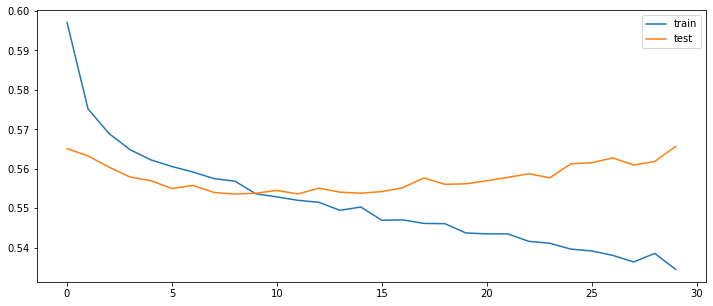

In [ ]:
# plot history
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 12,5

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
model.save("./part3models/")


INFO:tensorflow:Assets written to: ./part3models/assets


In [ ]:
from tensorflow import keras
model = keras.models.load_model('./part3models/')

In [ ]:
# make a prediction
yhat = model.predict(test_X_val)
# Convert to 1 and 0
test_y_val_bool = test_y_val.reshape(len(test_y_val))
yhat_bool = yhat.round().reshape(len(yhat))

In [ ]:
from sklearn.metrics import precision_score, recall_score
print("Precision: {:.2f} %%".format(precision_score(test_y_val_bool, yhat_bool) * 100))
print("Recall: {:.2f} %%".format(recall_score(test_y_val_bool, yhat_bool) * 100))

Precision: 72.07 %%
Recall: 61.19 %%
